In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3.common import results_plotter
from stable_baselines3.common.results_plotter import ts2xy, window_func
from stable_baselines3.common.monitor import load_results
from zfa.core.default_dirs import MODEL_CKPT_DIR

import socket
if not socket.gethostname().startswith("node"):
    MODEL_CKPT_DIR = os.path.expanduser("~/Desktop/")
    print(f"Switching to {MODEL_CKPT_DIR}")
    
EASY_MODEL_LOG_DIR = os.path.join(MODEL_CKPT_DIR, "easy_swimmer3_novision_unityenv_mlp300200_mlp400300_ppo_seed1_numparallel25/")
MODEL_LOG_DIR = os.path.join(MODEL_CKPT_DIR, "swimmer3_novision_unityenv_mlp300200_mlp400300_ppo_seed1_numparallel25/")

/om2/user/anayebi/miniconda/envs/pong_env/lib/python3.9/site-packages/glfw/__init__.py:916: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
/om2/user/anayebi/miniconda/envs/pong_env/lib/python3.9/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/om2/user/anayebi/miniconda/envs/pong_env/lib/python3.9/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
2023-09-08 15:03:16.977712: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow wi

In [2]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()

from typing import Callable, List, Optional, Tuple
EPISODES_WINDOW = 100
def plot_curves(
    xy_list: List[Tuple[np.ndarray, np.ndarray]], x_axis: str, title: str, figsize: Tuple[int, int] = (8, 2)
) -> None:
    """
    plot the curves

    :param xy_list: the x and y coordinates to plot
    :param x_axis: the axis for the x and y output
        (can be X_TIMESTEPS='timesteps', X_EPISODES='episodes' or X_WALLTIME='walltime_hrs')
    :param title: the title of the plot
    :param figsize: Size of the figure (width, height)
    """

    plt.figure(title, figsize=figsize)
    max_x = max(xy[0][-1] for xy in xy_list)
    min_x = 0
    for _, (x, y) in enumerate(xy_list):
        plt.scatter(x, y, s=2)
        # Do not plot the smoothed curve at all if the timeseries is shorter than window size.
        if x.shape[0] >= EPISODES_WINDOW:
            # Compute and plot rolling mean with window of size EPISODE_WINDOW
            x, y_mean = window_func(x, y, EPISODES_WINDOW, np.mean)
            plt.plot(x, y_mean, color="r")
    plt.xlim(min_x, max_x)
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel("Episode Rewards")
    plt.tight_layout()


def plot_results_scatter(
    dirs: List[str], num_timesteps: Optional[int], x_axis: str, task_name: str, figsize: Tuple[int, int] = (8, 2)
) -> None:
    """
    Plot the results using csv files from ``Monitor`` wrapper.

    :param dirs: the save location of the results to plot
    :param num_timesteps: only plot the points below this value
    :param x_axis: the axis for the x and y output
        (can be X_TIMESTEPS='timesteps', X_EPISODES='episodes' or X_WALLTIME='walltime_hrs')
    :param task_name: the title of the task to plot
    :param figsize: Size of the figure (width, height)
    """

    data_frames = []
    for folder in dirs:
        data_frame = load_results(folder)
        if num_timesteps is not None:
            data_frame = data_frame[data_frame.l.cumsum() <= num_timesteps]
        data_frames.append(data_frame)
    xy_list = [ts2xy(data_frame, x_axis) for data_frame in data_frames]
    plot_curves(xy_list, x_axis, task_name, figsize)
    

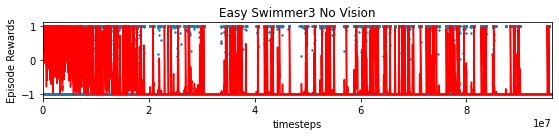

In [11]:
plot_results_scatter([EASY_MODEL_LOG_DIR], 1.1e8, results_plotter.X_TIMESTEPS, "Easy Swimmer3 No Vision")

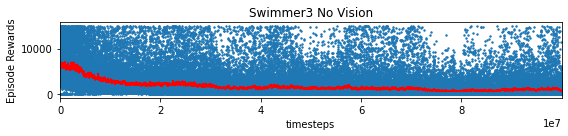

In [12]:
plot_results_scatter([MODEL_LOG_DIR], 1.1e8, results_plotter.X_TIMESTEPS, "Swimmer3 No Vision")

In [14]:
import re

# Get all files in the directory
files = os.listdir(EASY_MODEL_LOG_DIR)

# Filter for files that match the pattern and extract N
matches = [re.search(r'_(\d+)_steps\.zip$', file) for file in files]
valid_files = [(int(match.group(1)), file) for match, file in zip(matches, files) if match]

# Find the filename with the largest N
if valid_files:
    max_N_file = max(valid_files, key=lambda x: x[0])[1]
    print("File with the largest N:", max_N_file)
else:
    print("No matching files found.")

File with the largest N: easy_swimmer3_novision_unityenv_mlp300200_mlp400300_ppo_seed1_numparallel25_96000000_steps.zip


# 2. Visually Evaluate Policy from Camera

## 2a. Simple environment with reward closeby

### 2ai. Trained PPO

In [ ]:
import torch
import torch.nn as nn

os.environ["MUJOCO_GL"] = "egl"
if torch.cuda.is_available():
    print("Using GPU")
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    device = torch.device("cuda")
else:
    print("Using CPU")
    device = torch.device("cpu")
    
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor

from zfa.model_training.train_sb3unity_ppo import make_env
from zfa.core.default_dirs import UNITY_BUILDS_DIR

SWIMMER3_UNITY_GRAPHICS = os.path.expanduser("~/Zebrafish/topdown_swimmer3_zebrafish_build_macosx.app")
EASY_SWIMMER3_UNITY_GRAPHICS = os.path.expanduser("~/Zebrafish/topdown_easy_swimmer3_zebrafish_build_macosx.app")

def make_env_nosubproc(env_path, rank=0, seed=1):
    from mlagents_envs.environment import UnityEnvironment
    from zfa.model_training.envs import UnityToGymWrapperIgnorePixels
    from stable_baselines3.common.utils import set_random_seed
    from stable_baselines3.common.monitor import Monitor
    #from stable_baselines3.common.vec_env import VecEnv
    
    env = UnityEnvironment(env_path, worker_id=rank, seed=seed + rank)
    env = UnityToGymWrapperIgnorePixels(env, allow_multiple_obs=True)
    env = Monitor(env)
    set_random_seed(seed, using_cuda=torch.cuda.is_available())
    return env

# eval_env = SubprocVecEnv(
#     [
#         make_env(
#             env_path=SWIMMER3_UNITY_ENV_PATH_LINUX,
#             rank=rank,
#             seed=100,
#         )
#         for rank in range(1)
#     ]
# )
# # wrap it to log metrics
# eval_env = VecMonitor(eval_env)

eval_env = make_env_nosubproc(
#         env_path=SWIMMER3_UNITY_GRAPHICS,
        env_path=EASY_SWIMMER3_UNITY_GRAPHICS,
        rank=0,
        seed=100,
    )

model = PPO.load(path=os.path.join(MODEL_CKPT_DIR, "easy_swimmer3_novision_unityenv_mlp300200_mlp400300_ppo_seed1_numparallel25_96000000_steps"),
              env=eval_env)
returns, ep_lens = evaluate_policy(model, model.get_env(), 
                                   deterministic=True, render=True, 
                                   return_episode_rewards=True, n_eval_episodes=1000)

Using CPU
[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-all

/Users/anayebi/Library/Python/3.9/lib/python/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/Users/anayebi/Library/Python/3.9/lib/python/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:234: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


Wrapping the env in a DummyVecEnv.


In [4]:
returns

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.

### 2aii. Untrained PPO

In [2]:
import torch
import torch.nn as nn

os.environ["MUJOCO_GL"] = "egl"
if torch.cuda.is_available():
    print("Using GPU")
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    device = torch.device("cuda")
else:
    print("Using CPU")
    device = torch.device("cpu")
    
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor

from zfa.model_training.train_sb3unity_ppo import make_env
from zfa.core.default_dirs import UNITY_BUILDS_DIR

SWIMMER3_UNITY_GRAPHICS = os.path.expanduser("~/Zebrafish/topdown_swimmer3_zebrafish_build_macosx.app")
EASY_SWIMMER3_UNITY_GRAPHICS = os.path.expanduser("~/Zebrafish/topdown_easy_swimmer3_zebrafish_build_macosx.app")

def make_env_nosubproc(env_path, rank=0, seed=1):
    from mlagents_envs.environment import UnityEnvironment
    from zfa.model_training.envs import UnityToGymWrapperIgnorePixels
    from stable_baselines3.common.utils import set_random_seed
    from stable_baselines3.common.monitor import Monitor
    #from stable_baselines3.common.vec_env import VecEnv
    
    env = UnityEnvironment(env_path, worker_id=rank, seed=seed + rank)
    env = UnityToGymWrapperIgnorePixels(env, allow_multiple_obs=True)
    env = Monitor(env)
    set_random_seed(seed, using_cuda=torch.cuda.is_available())
    return env

# eval_env = SubprocVecEnv(
#     [
#         make_env(
#             env_path=SWIMMER3_UNITY_ENV_PATH_LINUX,
#             rank=rank,
#             seed=100,
#         )
#         for rank in range(1)
#     ]
# )
# # wrap it to log metrics
# eval_env = VecMonitor(eval_env)

eval_env = make_env_nosubproc(
#         env_path=SWIMMER3_UNITY_GRAPHICS,
        env_path=EASY_SWIMMER3_UNITY_GRAPHICS,
        rank=0,
        seed=100,
    )

model = PPO(
    "MlpPolicy",
    eval_env,
    verbose=1,
    device=device,
    policy_kwargs=dict(
    activation_fn=nn.ReLU, net_arch=dict(pi=[300, 200], vf=[400, 300]))
)
returns_rand, ep_lens = evaluate_policy(model, model.get_env(), 
                                   deterministic=True, render=True, 
                                   return_episode_rewards=True, 
                                   n_eval_episodes=1000)

Using CPU
[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-all

/Users/anayebi/Library/Python/3.9/lib/python/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/Users/anayebi/Library/Python/3.9/lib/python/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:234: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


Using cpu device
Wrapping the env in a DummyVecEnv.


In [3]:
returns_rand

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

## 2b. Original harder environment

In [ ]:
import torch
import torch.nn as nn

os.environ["MUJOCO_GL"] = "egl"
if torch.cuda.is_available():
    print("Using GPU")
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    device = torch.device("cuda")
else:
    print("Using CPU")
    device = torch.device("cpu")
    
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor

from zfa.model_training.train_sb3unity_ppo import make_env
from zfa.core.default_dirs import UNITY_BUILDS_DIR

SWIMMER3_UNITY_GRAPHICS = os.path.expanduser("~/Zebrafish/topdown_swimmer3_zebrafish_build_macosx.app")
EASY_SWIMMER3_UNITY_GRAPHICS = os.path.expanduser("~/Zebrafish/topdown_easy_swimmer3_zebrafish_build_macosx.app")

def make_env_nosubproc(env_path, rank=0, seed=1):
    from mlagents_envs.environment import UnityEnvironment
    from zfa.model_training.envs import UnityToGymWrapperIgnorePixels
    from stable_baselines3.common.utils import set_random_seed
    from stable_baselines3.common.monitor import Monitor
    #from stable_baselines3.common.vec_env import VecEnv
    
    env = UnityEnvironment(env_path, worker_id=rank, seed=seed + rank)
    env = UnityToGymWrapperIgnorePixels(env, allow_multiple_obs=True)
    env = Monitor(env)
    set_random_seed(seed, using_cuda=torch.cuda.is_available())
    return env

# eval_env = SubprocVecEnv(
#     [
#         make_env(
#             env_path=SWIMMER3_UNITY_ENV_PATH_LINUX,
#             rank=rank,
#             seed=100,
#         )
#         for rank in range(1)
#     ]
# )
# # wrap it to log metrics
# eval_env = VecMonitor(eval_env)

eval_env = make_env_nosubproc(
        env_path=SWIMMER3_UNITY_GRAPHICS,
#         env_path=EASY_SWIMMER3_UNITY_GRAPHICS,
        rank=0,
        seed=100,
    )

model = PPO.load(os.path.join(MODEL_CKPT_DIR, "swimmer3_novision_unityenv_mlp300200_mlp400300_ppo_seed1_numparallel25_96000000_steps"),
              env=eval_env)
returns, ep_lens = evaluate_policy(model, model.get_env(), 
                                   deterministic=True, render=True, 
                                   return_episode_rewards=True, n_eval_episodes=10)

Using CPU
[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-all

/Users/anayebi/Library/Python/3.9/lib/python/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/Users/anayebi/Library/Python/3.9/lib/python/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:234: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


Wrapping the env in a DummyVecEnv.


# 3. Looking at DM Control PPO SB3 results

In [5]:
SWIMMER3_DM_DIR = os.path.join(MODEL_CKPT_DIR, "swimmer3_dmcontrolenv_mlp300200_mlp400300_ppo_seed1_numparallel25/")
SWIMMER6_DM_DIR = os.path.join(MODEL_CKPT_DIR, "swimmer6_dmcontrolenv_mlp300200_mlp400300_ppo_seed1_numparallel25/")

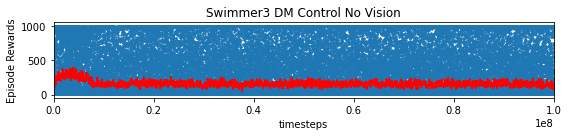

In [8]:
plot_results_scatter([SWIMMER3_DM_DIR], 1.1e8, results_plotter.X_TIMESTEPS, "Swimmer3 DM Control No Vision")

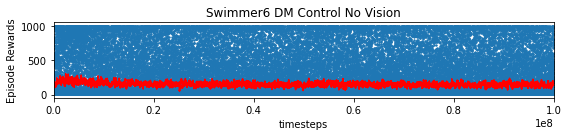

In [9]:
plot_results_scatter([SWIMMER6_DM_DIR], 1.1e8, results_plotter.X_TIMESTEPS, "Swimmer6 DM Control No Vision")

In [2]:
import torch
import torch.nn as nn

# use this: https://github.com/deepmind/dm_control/issues/223
os.environ["MUJOCO_GL"] = "glfw"
if torch.cuda.is_available():
    print("Using GPU")
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    device = torch.device("cuda")
else:
    print("Using CPU")
    device = torch.device("cpu")
    
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

def make_env_nosubproc(task_name, rank=0, seed=1):
    from zfa.model_training.envs import DMSuiteEnv
    from stable_baselines3.common.utils import set_random_seed
    from stable_baselines3.common.monitor import Monitor
    
    env = DMSuiteEnv(
                domain_name="swimmer",
                task_name=task_name,
                task_kwargs={"random": seed + rank},
            )
    env = Monitor(env)
    set_random_seed(seed, using_cuda=torch.cuda.is_available())
    return env

task_name = "swimmer6"
eval_env = make_env_nosubproc(
        task_name=task_name,
        rank=0,
        seed=100,
    )

model = PPO.load(os.path.join(MODEL_CKPT_DIR, f"{task_name}_dmcontrolenv_mlp300200_mlp400300_ppo_seed1_numparallel25_final_model"),
              env=eval_env)
returns, ep_lens = evaluate_policy(model, model.get_env(), 
                                   deterministic=True, render=True, 
                                   return_episode_rewards=True, n_eval_episodes=10)

Using CPU


/Users/anayebi/Library/Python/3.9/lib/python/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Wrapping the env in a DummyVecEnv.


/Users/anayebi/Library/Python/3.9/lib/python/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:234: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


In [4]:
returns

[4.981692,
 8.169282,
 9.963455,
 15.6946,
 6.219787,
 5.27222,
 26.54644,
 14.669126,
 48.661173,
 9.045214]

In [6]:
returns

[7.533166,
 9.430434,
 434.384037,
 4.630191,
 7.027802,
 74.87915,
 100.583617,
 17.128188,
 739.162129,
 28.615653]

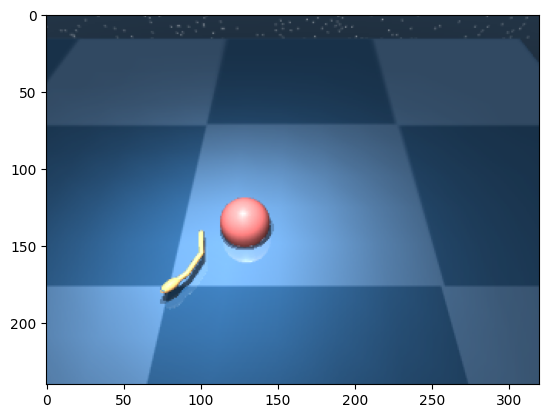

In [26]:
plt.imshow(model.get_env().envs[0].env.env.physics.render())

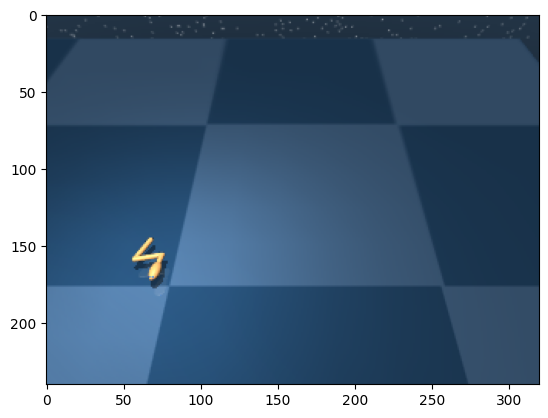

In [ ]:
from IPython import display
# Run the trained policy and visualize
obs = eval_env.reset()
for i in range(1000):
    action, _ = model.predict(obs[0] if i == 0 else obs, deterministic=True)
    obs, reward, done, trunc, info = eval_env.step(action)
    
    # Render to array
#     img = eval_env.render()
    img = eval_env.env.env.physics.render()
    # Display in notebook
    plt.imshow(img)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    if done:
        obs = eval_env.reset()

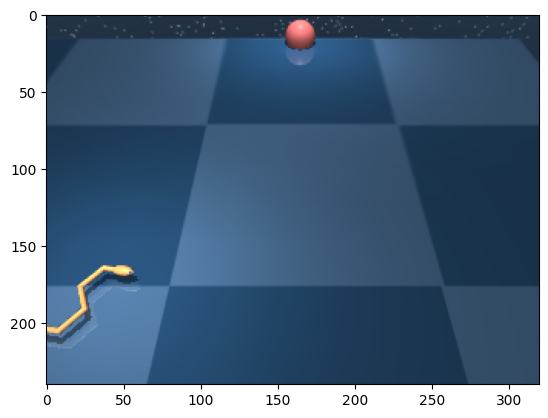

In [ ]:
from IPython import display
# Run the trained policy and visualize
obs = eval_env.reset()
for i in range(1000):
    action, _ = model.predict(obs[0] if i == 0 else obs, deterministic=True)
    obs, reward, done, trunc, info = eval_env.step(action)
    
    # Render to array
#     img = eval_env.render()
    img = eval_env.env.env.physics.render()
    # Display in notebook
    plt.imshow(img)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    if done:
        obs = eval_env.reset()

# 4. Looking at DM Control PPO RL Zoo SB3 results (NOTE: hyperparameter optimization was not run)

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["MUJOCO_GL"] = "egl"
# uncomment if using enjoy, otherwise leads to OpenGL issue, according to: https://github.com/openai/mujoco-py/issues/187
# os.environ["LD_PRELOAD"] = "/om2/user/anayebi/local_glew/lib64/libGLEW.so"

Mac OS X:

In [ ]:
!python3 -m rl_zoo3.enjoy --verbose 1 --algo ppo --env Swimmer-v3 --folder /Users/anayebi/Desktop/ --exp-id 3 --load-best

[autoreload of torch.overrides failed: Traceback (most recent call last):
  File "/Users/anayebi/Library/Python/3.9/lib/python/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/anayebi/Library/Python/3.9/lib/python/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/Users/anayebi/Library/Python/3.9/lib/python/site-packages/torch/overrides.py", line 33, in <module>
    from torch._C import (
ImportError: cannot import name '_push_on_torch_function_stack' from '

[autoreload of torch.cuda failed: Traceback (most recent call last):
  File "/Users/anayebi/Library/Python/3.9/lib/python/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/anayebi/Library/Python/3.9/lib/python/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/Users/anayebi/Library/Python/3.9/lib/python/site-packages/torch/cuda/__init__.py", line 22, in <module>
    from .graphs import CUDAGraph, graph_pool_handle, graph, \
ImportError: cannot import name 'is

Linux:

First run this in:
```
ssh -Y om
screen -S [yoursession]
srun --x11 --mem=10G -t 168:00:00 -p yanglab --gres=gpu:1 -N1 -n1 --constraint=vgl --pty bash
jupyter notebook --ip=0.0.0.0 --port=9000 --no-browser
```

In [3]:
# uncomment if using enjoy, in order to deal with the version not displayed
# !pip install pyvirtualdisplay
# from pyvirtualdisplay import Display
# display = Display(visible=0, size=(1400, 900))
# display.start()

# import glfw
# glfw.window_hint(glfw.CONTEXT_VERSION_MAJOR, 3)
# glfw.window_hint(glfw.CONTEXT_VERSION_MINOR, 3)

/om2/user/anayebi/miniconda/envs/pong_env/lib/python3.9/site-packages/glfw/__init__.py:916: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)


In [3]:
!python3 -m rl_zoo3.enjoy --verbose 1 --algo ppo --env Swimmer-v3 --folder /om/weka/yanglab/anayebi/zfa/logs/ --exp-id 3 --load-best

/om2/user/anayebi/miniconda/envs/pong_env/lib/python3.9/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/om2/user/anayebi/miniconda/envs/pong_env/lib/python3.9/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
2023-09-08 21:34:02.279406: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 21:34:03.990286: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: 

In [3]:
!python3 -m rl_zoo3.record_video --algo ppo --n-timesteps 1000 --env Swimmer-v3 --folder /om/weka/yanglab/anayebi/zfa/logs/ --exp-id 3 --load-best

/om2/user/anayebi/miniconda/envs/pong_env/lib/python3.9/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/om2/user/anayebi/miniconda/envs/pong_env/lib/python3.9/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
2023-09-09 09:00:20.388573: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-09 09:00:24.407445: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: 

In [4]:
import stable_baselines3 as sb3; sb3.get_system_info()

/om2/user/anayebi/miniconda/envs/pong_env/lib/python3.9/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/om2/user/anayebi/miniconda/envs/pong_env/lib/python3.9/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
2023-09-09 09:30:12.391576: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-09 09:30:15.374693: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: 

- OS: Linux-3.10.0-1062.el7.x86_64-x86_64-with-glibc2.17 # 1 SMP Wed Aug 7 18:08:02 UTC 2019
- Python: 3.9.7
- Stable-Baselines3: 2.1.0
- PyTorch: 2.0.0+cu117
- GPU Enabled: True
- Numpy: 1.21.2
- Cloudpickle: 2.0.0
- Gymnasium: 0.28.1
- OpenAI Gym: 0.26.2



({'OS': 'Linux-3.10.0-1062.el7.x86_64-x86_64-with-glibc2.17 # 1 SMP Wed Aug 7 18:08:02 UTC 2019',
  'Python': '3.9.7',
  'Stable-Baselines3': '2.1.0',
  'PyTorch': '2.0.0+cu117',
  'GPU Enabled': 'True',
  'Numpy': '1.21.2',
  'Cloudpickle': '2.0.0',
  'Gymnasium': '0.28.1',
  'OpenAI Gym': '0.26.2'},
 '- OS: Linux-3.10.0-1062.el7.x86_64-x86_64-with-glibc2.17 # 1 SMP Wed Aug 7 18:08:02 UTC 2019\n- Python: 3.9.7\n- Stable-Baselines3: 2.1.0\n- PyTorch: 2.0.0+cu117\n- GPU Enabled: True\n- Numpy: 1.21.2\n- Cloudpickle: 2.0.0\n- Gymnasium: 0.28.1\n- OpenAI Gym: 0.26.2\n')